In [1]:
%matplotlib widget
# %matplotlib qt
import matplotlib.pyplot as plt
import numpy as np
import bmcs_utils.api as bu
from bmcs_cross_section.api import MKappa, TShape, EC2, BarLayer, ReinfLayer
from bmcs_beam.api import SLSParamStudy, BoundaryConditions, BoundaryConfig, DeflectionProfile, BeamDesign, BeamSLSCurve, LoadDeflectionParamsStudy
from mpl_toolkits import mplot3d


$q_{GZT}$ = F_u in the code\
$q_{GZG}$ = F_s in the code\
$\gamma_{carbon}$ 1.3/(0.85*0.9)

NameError: name 'b_sls' is not defined

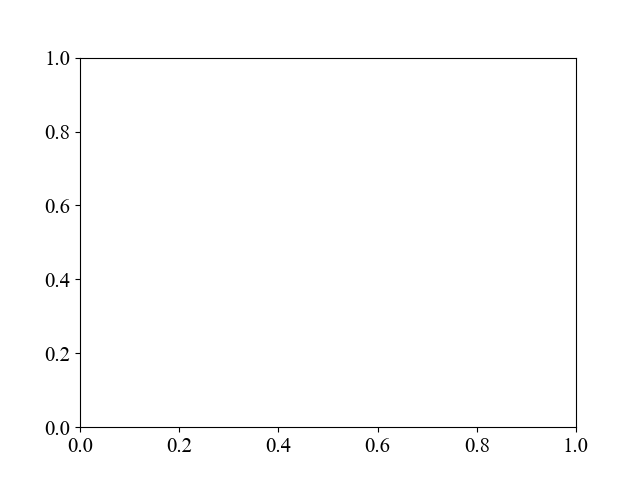

In [2]:
fig, ax = plt.subplots()
b_sls.plot_with_ec2_curves(b_sls.F_u_grid, b_sls.F_s_grid, b_sls.rho_grid, b_sls.sl_grid, ax)
fig
fig.savefig('biegeversuche_properties_300_100_section_4pb.pdf')

In [4]:
b_sls = BeamSLSCurve(f_ck=96.96-8, use_f_ctm_fl=False, rein_type = 'carbon_grid', system_type = '4pb', n_i=20)
ps = SLSParamStudy(b_sls)
b_sls.interact()

parameter combination 0.005421052631578948 35.15789473684211
dp updated!
dp updated!
dp updated!
dp updated!


Exception in thread Thread-6:
Traceback (most recent call last):
  File "C:\Users\hspartali\Anaconda3\envs\bmcs_env\lib\threading.py", line 973, in _bootstrap_inner


parameter combination 0.005421052631578948 50.0


In [17]:
# b_sls = BeamSLSCurve()
# ps = SLSParamStudy(b_sls)

dp updated!


In [3]:
# b_sls.interact()

start thread
run started...
parameter combination 0.0002 3.0


In [21]:
b_sls.n_i = 10

In [19]:
b_sls.rein_type = 'carbon_grid'
b_sls.dense_quarter = True

dp updated!


In [ ]:
# fig, ax = plt.subplots()
# ax.vlines(b_sls.rho_range, ymin=0, ymax=50)
# ax.hlines(b_sls.slenderness_range, xmin=0, xmax=0.025)

In [5]:
b_sls.concrete_law = 'EC2 with plateau'

dp updated!


In [5]:
b_sls.f_ctm

5.140581778522786

In [8]:
b_sls.f_ck = 70

dp updated!


In [14]:
EC2.get_f_ctm(70)

4.610473649546422

In [13]:
EC2.get_f_ctm_fl(70, 300)

5.993615744410349

In [36]:
b_sls.concrete_law = 'EC2 with plateau'

dp updated!


In [21]:
EC2.get_f_ctm_fl(b_sls.f_ck, 300)

5.993615744410349

In [22]:
b_sls.f_ck = 30

dp updated!


In [4]:
b_sls.apply_material_factors = False

False

In [3]:
b_sls.apply_material_factors = True
b_sls.use_f_ctm_fl = False
b_sls.concrete_law = 'EC2'

dp updated!


In [29]:
2 * EC2.get_f_ctm_fl(70, 300)

11.987231488820697

Parametric study is running...
f_t, E: (1500, 160000), parameter combination 0.0002 3.0
parameter combination 0.0002 5.35
parameter combination 0.0002 7.7
parameter combination 0.0002 10.05
parameter combination 0.0002 12.4
parameter combination 0.0002 14.75
parameter combination 0.0002 23.5625
parameter combination 0.0002 32.375
parameter combination 0.0002 41.1875
parameter combination 0.0002 50.0
parameter combination 0.0014400000000000003 3.0
parameter combination 0.0014400000000000003 5.35
parameter combination 0.0014400000000000003 7.7
parameter combination 0.0014400000000000003 10.05
parameter combination 0.0014400000000000003 12.4
parameter combination 0.0014400000000000003 14.75
parameter combination 0.0014400000000000003 23.5625
parameter combination 0.0014400000000000003 32.375
parameter combination 0.0014400000000000003 41.1875
parameter combination 0.0014400000000000003 50.0
parameter combination 0.0026800000000000005 3.0
parameter combination 0.0026800000000000005 5.35
pa

parameter combination 0.025 5.35
parameter combination 0.025 7.7
parameter combination 0.025 10.05
parameter combination 0.025 12.4
parameter combination 0.025 14.75
parameter combination 0.025 23.5625
parameter combination 0.025 32.375
parameter combination 0.025 41.1875
parameter combination 0.025 50.0
(4500, 250000), parameter combination 0.0002 3.0
parameter combination 0.0002 5.35
parameter combination 0.0002 7.7
parameter combination 0.0002 10.05
parameter combination 0.0002 12.4
parameter combination 0.0002 14.75
parameter combination 0.0002 23.5625
parameter combination 0.0002 32.375
parameter combination 0.0002 41.1875
parameter combination 0.0002 50.0
parameter combination 0.0014400000000000003 3.0
parameter combination 0.0014400000000000003 5.35
parameter combination 0.0014400000000000003 7.7
parameter combination 0.0014400000000000003 10.05
parameter combination 0.0014400000000000003 12.4
parameter combination 0.0014400000000000003 14.75
parameter combination 0.001440000000

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
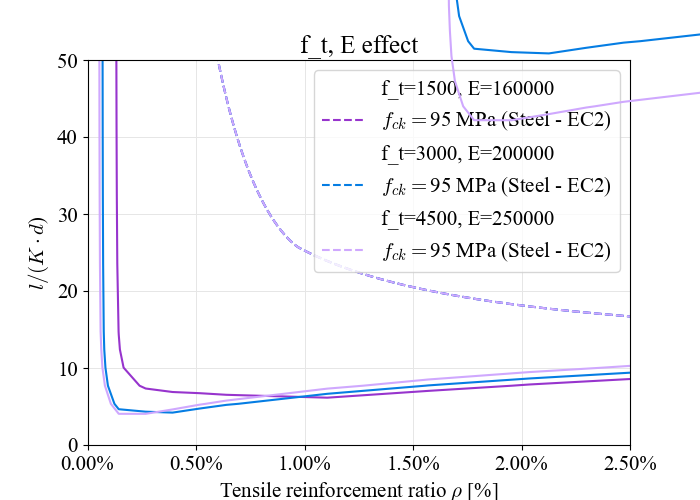

In [22]:
params_config = [
#     ['f_ctm', b_sls, [1* EC2.get_f_ctm_fl(b_sls.f_ck, 300), 2* EC2.get_f_ctm_fl(b_sls.f_ck, 300)]],
#     [['f_ck', b_sls, [30, 50, 70]], ['f_ctm', b_sls, [7.5, 10.58, 12]]],
#         [['f_ck', b_sls, [10]], ['f_ctm', b_sls, [4]]],
#     ['f_ck', b_sls, [50, 100]],
#     ['sls_to_uls_ratio', b_sls, [0.59, 0.51]]
#     ['concrete_law', b_sls, ['EC2 with plateau', 'EC2']],
#     ['n_i', b_sls, [5, 11, 15]],
#     ['dense_quarter', b_sls, [True, False]],
#     ['use_f_ctm_fl', b_sls, [True, False]],
#     ['apply_material_factors', b_sls, [True, False]],
#     ['rein_type', b_sls, ['carbon_grid', 'carbon_rebars']],
#     ['H', b_sls.dp.mc.cross_section_shape_, [200, 400, 600]],
#     ['B', b_sls.dp.mc.cross_section_shape_, [1000, 500, 200]],
#     [['B', b_sls.dp.mc.cross_section_shape_, [1000, 200, 300]], ['H', b_sls.dp.mc.cross_section_shape_, [300, 400, 700]]],
    [['f_t', b_sls.dp.mc.cross_section_layout.items[0].matmod_, [1500, 3000, 4500]], ['E', b_sls.dp.mc.cross_section_layout.items[0].matmod_, [160000, 200000, 250000]]],
    ]
fig = ps.run(params_config, savefig=True)

In [ ]:
# sls.plot_F_u()
sls.plot_F_u(bending_shear_diff = True)
# sls.plot_F_u(load='shear')


# Achse x: Bewehrungsgrad rho [%]
# Achse y: Biegeschlankheit l/d [-]

## Tensile vs compression failure zones

In [ ]:
dp = b_sls.dp
mc = dp.mc
# for rho in b_sls.rho_range:
#     area_g = mc.cross_section_shape_.get_cs_area()
#     A_j_g = rho * area_g
#     mc.cross_section_layout.items[0].A = A_j_g
#     mc.M_t / mc.M_scale

In [ ]:
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(b_sls.rho_grid, b_sls.sl_grid, b_sls.F_u_grid,
                       linewidth=0, antialiased=False, cmap=cm.coolwarm)

In [ ]:
np.linspace(0, 5000, 30)
fig, ax = plt.subplots()
# z = b_sls.F_u_grid / b_sls.F_s_grid - 1. / b_sls.sls_to_uls_ratio
z = b_sls.F_u_grid
cs = ax.contour(b_sls.rho_grid, b_sls.sl_grid, z, levels=[0, 10, 20, 50, 80, 100, 150, 300, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000])
ax.clabel(cs, inline=True, fontsize=10)

### 1. EC2 - Steel

In [ ]:
b_sls.n_i = 10
b_sls.rein_type = 'steel'
b_sls.dense_quarter = False

### 2. EC2 - Carbon

In [ ]:
b_sls.n_i = 10
b_sls.rein_type = 'carbon_grid'
b_sls.dense_quarter = True